AutoGAN Model

Load,EDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis


In [2]:
# Load the datasets
df1 = pd.read_csv('updated_fraud_transactions.csv')
df2 = pd.read_csv('customer_dataset 1.csv')

# Merge the datasets
df = pd.merge(df1, df2, left_on='Sender Account ID', right_on='Customer ID')

print(df.head())
print(df.info())

  Transaction ID            Timestamp  Sender Account ID Transaction Type  \
0         T00001  2023-08-14 08:37:07              10095         Transfer   
1         T00002  2023-12-04 12:54:11              10098         Transfer   
2         T00003  2023-07-09 23:16:11              10097           Credit   
3         T00004  2023-06-26 07:04:39              10039           Credit   
4         T00005  2023-09-28 02:40:56              10018            Debit   

  IN_OUT   Amount Recipient Bank  Fraud  Customer ID                    Name  \
0     In  4887.67          B0004      0        10095        Dilshan De Alwis   
1     In  2371.33         B00010      0        10098      Ruwan Samarasinghe   
2     In  4733.44          B0008      0        10097             Sarath Dias   
3     In  1544.12          B0005      0        10039            Nadeeka Dias   
4    Out  3978.04          B0004      0        10018  Chathura Hettiarachchi   

   Age    Location Gender Account Type  Device Count  
0

In [3]:
# Check class distribution
print(df['Fraud'].value_counts(normalize=True))

Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64


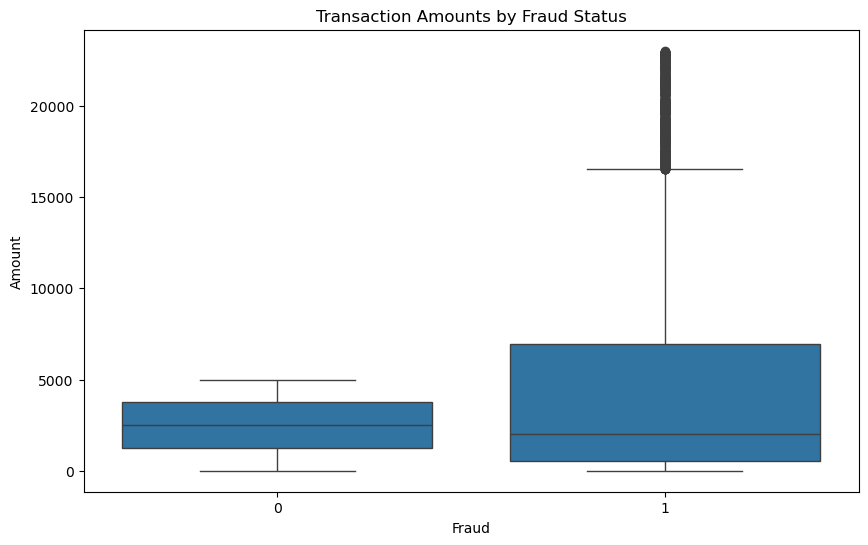

In [4]:
# Visualize transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=df)
plt.title('Transaction Amounts by Fraud Status')
plt.show()

In [5]:
# Outlier detection and treatment (example using IQR method for 'Amount')
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Amount'] = np.where(df['Amount'] > upper_bound, upper_bound, df['Amount'])
df['Amount'] = np.where(df['Amount'] < lower_bound, lower_bound, df['Amount'])

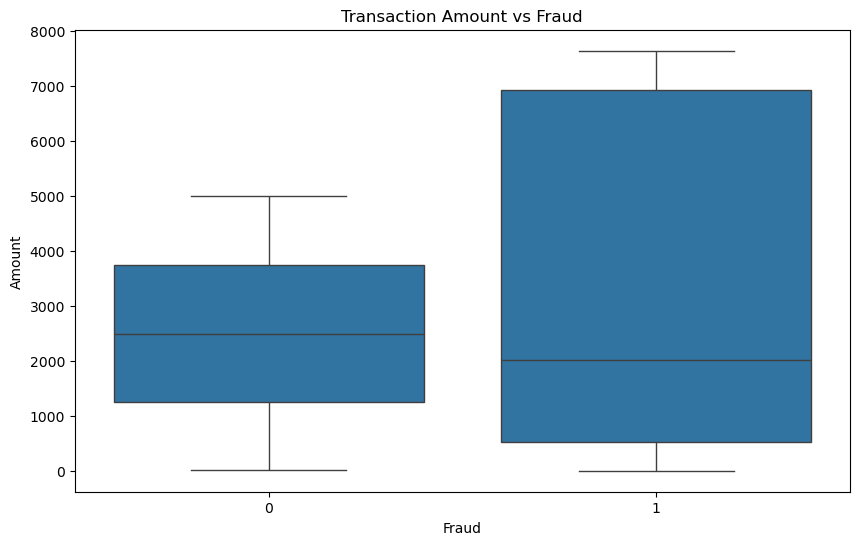

In [6]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=df)
plt.title('Transaction Amount vs Fraud')
plt.show()


In [7]:
# Analyze transaction types
fraud_by_type = df.groupby('Transaction Type')['Fraud'].mean().sort_values(ascending=False)
print("Fraud rate by transaction type:")
print(fraud_by_type)

Fraud rate by transaction type:
Transaction Type
Transfer    0.087193
Debit       0.036431
Payment     0.036109
Credit      0.034439
Name: Fraud, dtype: float64


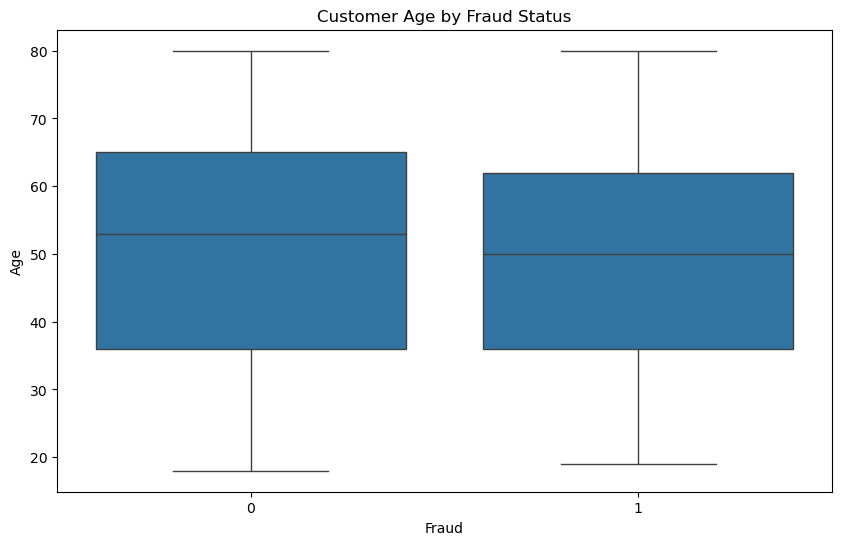

In [8]:
# Analyze customer age and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Age', data=df)
plt.title('Customer Age by Fraud Status')
plt.show()

Feature Engineering

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Ensure Timestamp is in datetime format and sort the dataframe
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['Sender Account ID', 'Timestamp']).reset_index(drop=True)

# Existing features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['AmountLog'] = np.log1p(df['Amount'])
df['AmountPerDevice'] = df['Amount'] / df['Device Count']
transaction_frequency = df.groupby('Sender Account ID')['Transaction ID'].count()
df['TransactionFrequency'] = df['Sender Account ID'].map(transaction_frequency)
df['IsHighRiskLocation'] = df['Location'].isin(['Colombo', 'Negombo', 'Kandy']).astype(int)
df['IsNewCustomer'] = (df['Age'] < 25).astype(int)

# New time-based features
df['DayOfMonth'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 5)).astype(int)

# Custom function for time-based features
def calculate_time_based_features(group, window_days):
    end_times = group['Timestamp']
    start_times = end_times - pd.Timedelta(days=window_days)
    
    counts = []
    amounts = []
    
    for start, end in zip(start_times, end_times):
        mask = (group['Timestamp'] > start) & (group['Timestamp'] <= end)
        counts.append(mask.sum())
        amounts.append(group.loc[mask, 'Amount'].sum())
    
    return pd.Series({
        f'TransactionCount_{window_days}d': counts,
        f'TransactionAmount_{window_days}d': amounts
    })

# Transaction velocity features
time_windows = [1, 7, 30]  # in days
for window in time_windows:
    new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))
    df = df.join(new_features, on='Sender Account ID')

# Amount statistics per customer
amount_stats = df.groupby('Sender Account ID')['Amount'].agg(['mean', 'std', 'min', 'max'])
df['AmountMean'] = df['Sender Account ID'].map(amount_stats['mean'])
df['AmountStd'] = df['Sender Account ID'].map(amount_stats['std'])
df['AmountMin'] = df['Sender Account ID'].map(amount_stats['min'])
df['AmountMax'] = df['Sender Account ID'].map(amount_stats['max'])
df['AmountZScore'] = (df['Amount'] - df['AmountMean']) / df['AmountStd'].replace(0, 1)

# Behavioral features
df['TransactionTimeDiff'] = df.groupby('Sender Account ID')['Timestamp'].diff().dt.total_seconds() / 3600
df['TransactionAmountDiff'] = df.groupby('Sender Account ID')['Amount'].diff()
df['TransactionAmountRatio'] = df['Amount'] / df.groupby('Sender Account ID')['Amount'].shift(1)

# Advanced statistical features
df['AmountSkew'] = df.groupby('Sender Account ID')['Amount'].transform(lambda x: skew(x) if len(x) > 2 else 0)
df['AmountKurtosis'] = df.groupby('Sender Account ID')['Amount'].transform(lambda x: kurtosis(x) if len(x) > 3 else 0)

# Interaction features
df['AmountPerFrequency'] = df['Amount'] / (df['TransactionFrequency'] + 1)
df['AmountPerAge'] = df['Amount'] / (df['Age'] + 1)

# Categorical encoding
df['RecipientBankEncoded'] = df['Recipient Bank'].map(df.groupby('Recipient Bank')['Fraud'].mean())
df['LocationEncoded'] = df['Location'].map(df.groupby('Location')['Fraud'].mean())

# Fill NaN values
df = df.fillna(0)

print(df.columns)
print(df.head())

/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_46808/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))
/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_46808/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').appl

Index(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Transaction Type',
       'IN_OUT', 'Amount', 'Recipient Bank', 'Fraud', 'Customer ID', 'Name',
       'Age', 'Location', 'Gender', 'Account Type', 'Device Count', 'Hour',
       'DayOfWeek', 'Weekend', 'AmountLog', 'AmountPerDevice',
       'TransactionFrequency', 'IsHighRiskLocation', 'IsNewCustomer',
       'DayOfMonth', 'Month', 'IsNightTime', 'TransactionCount_1d',
       'TransactionAmount_1d', 'TransactionCount_7d', 'TransactionAmount_7d',
       'TransactionCount_30d', 'TransactionAmount_30d', 'AmountMean',
       'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore',
       'TransactionTimeDiff', 'TransactionAmountDiff',
       'TransactionAmountRatio', 'AmountSkew', 'AmountKurtosis',
       'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded',
       'LocationEncoded'],
      dtype='object')
  Transaction ID           Timestamp  Sender Account ID Transaction Type  \
0         T10171 2023-01-01 02:15:40       

In [10]:
df.head()


,Transaction ID,Timestamp,Sender Account ID,Transaction Type,IN_OUT,Amount,Recipient Bank,Fraud,Customer ID,Name,...,AmountZScore,TransactionTimeDiff,TransactionAmountDiff,TransactionAmountRatio,AmountSkew,AmountKurtosis,AmountPerFrequency,AmountPerAge,RecipientBankEncoded,LocationEncoded
0,T10171,2023-01-01 02:15:40,10001,Debit,Out,7633.25,B0007,1,10001,Nimal Fernando,...,2.954768,0.000000,0.00,0.000000,0.656239,0.322797,7.332613,123.116935,0.029992,0.073025
1,T66189,2023-01-02 04:56:24,10001,Credit,In,3124.00,B0004,0,10001,Nimal Fernando,...,0.329935,26.678889,-4509.25,0.409262,0.656239,0.322797,3.000961,50.387097,0.087356,0.073025
2,T65558,2023-01-02 19:01:37,10001,Debit,Out,4045.80,B0004,0,10001,Nimal Fernando,...,0.866514,14.086944,921.80,1.295070,0.656239,0.322797,3.886455,65.254839,0.087356,0.073025
3,T00825,2023-01-03 03:40:02,10001,Payment,Out,1760.78,B0007,0,10001,Nimal Fernando,...,-0.463595,8.640278,-2285.02,0.435212,0.656239,0.322797,1.691431,28.399677,0.029992,0.073025
4,T10551,2023-01-03 07:30:46,10001,Debit,Out,3160.13,B0005,0,10001,Nimal Fernando,...,0.350966,3.845556,1399.35,1.794733,0.656239,0.322797,3.035668,50.969839,0.031423,0.073025


Feature Selection

In [11]:
# Print the column names to verify
print("Columns in the dataframe:")
print(df.columns)

Columns in the dataframe:
Index(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Transaction Type',
       'IN_OUT', 'Amount', 'Recipient Bank', 'Fraud', 'Customer ID', 'Name',
       'Age', 'Location', 'Gender', 'Account Type', 'Device Count', 'Hour',
       'DayOfWeek', 'Weekend', 'AmountLog', 'AmountPerDevice',
       'TransactionFrequency', 'IsHighRiskLocation', 'IsNewCustomer',
       'DayOfMonth', 'Month', 'IsNightTime', 'TransactionCount_1d',
       'TransactionAmount_1d', 'TransactionCount_7d', 'TransactionAmount_7d',
       'TransactionCount_30d', 'TransactionAmount_30d', 'AmountMean',
       'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore',
       'TransactionTimeDiff', 'TransactionAmountDiff',
       'TransactionAmountRatio', 'AmountSkew', 'AmountKurtosis',
       'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded',
       'LocationEncoded'],
      dtype='object')


In [12]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select all features except 'Fraud' (target variable) and any non-numeric columns
feature_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Fraud')


In [13]:
# Perform feature selection
selector = SelectKBest(f_classif, k=20)  # Select top 20 features
X_selected = selector.fit_transform(df[feature_cols], df['Fraud'])


In [14]:
# Get selected feature names
selected_features = feature_cols[selector.get_support()].tolist()

print("Selected features:", selected_features)


Selected features: ['Sender Account ID', 'Amount', 'Customer ID', 'Weekend', 'AmountLog', 'AmountPerDevice', 'TransactionFrequency', 'IsNightTime', 'AmountMean', 'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore', 'TransactionAmountDiff', 'AmountSkew', 'AmountKurtosis', 'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded', 'LocationEncoded']


Data Preprocessing

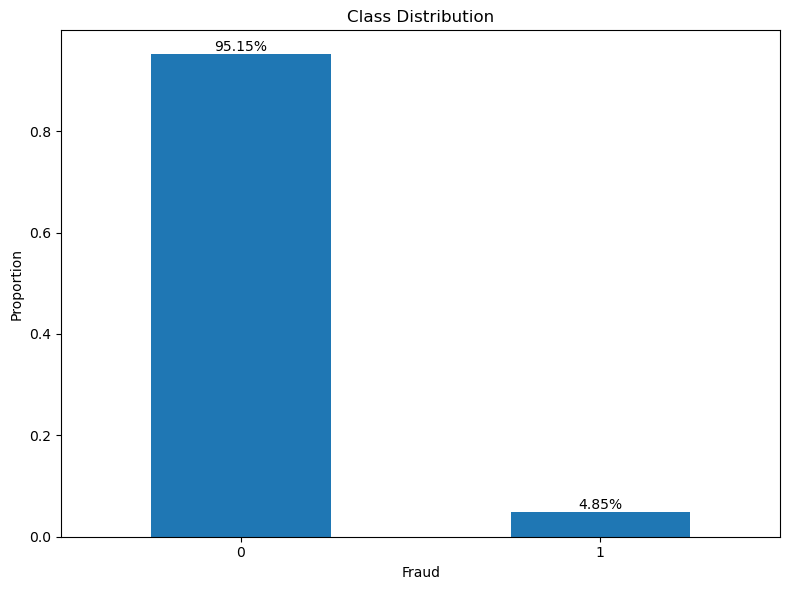

Class distribution:
Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64


In [15]:
import matplotlib.pyplot as plt

class_distribution = df['Fraud'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Fraud')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
for i, v in enumerate(class_distribution):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("Class distribution:")
print(class_distribution)

In [16]:
X = df[selected_features]
y = df['Fraud']


In [17]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
# Create a pipeline for preprocessing and balancing
preprocessing = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.8, random_state=42))
])

In [20]:
# Apply preprocessing to training data
X_train_balanced, y_train_balanced = preprocessing.fit_resample(X_train, y_train)


In [21]:
print("Original training set shape:", X_train.shape)
print("Balanced training set shape:", X_train_balanced.shape)
print("\nOriginal class distribution:")
print(y_train.value_counts(normalize=True))
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

Original training set shape: (80000, 20)
Balanced training set shape: (85632, 20)

Original class distribution:
Fraud
0    0.951475
1    0.048525
Name: proportion, dtype: float64

Balanced class distribution:
Fraud
0    0.555552
1    0.444448
Name: proportion, dtype: float64


AutoGAN model

In [22]:
class ModifiedAnoGAN:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        self.discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
        
        z = Input(shape=(self.latent_dim,))
        generated = self.generator(z)
        validity = self.discriminator(generated)
        
        self.combined = Model(z, validity)
        self.combined.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
    
    def build_generator(self):
        model = Sequential([
            Dense(128, input_dim=self.latent_dim),
            LeakyReLU(alpha=0.2),
            Dense(256),
            LeakyReLU(alpha=0.2),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dense(self.input_dim, activation='tanh')
        ])
        return model
    
    def build_discriminator(self):
        model = Sequential([
            Dense(512, input_dim=self.input_dim),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(256),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(128),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        return model

    
    def train(self, X_train, epochs, batch_size, sample_interval=100):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # Train discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_samples = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            generated_samples = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(real_samples, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_samples, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            
            if epoch % sample_interval == 0:
                print(f"Epoch {epoch}, D Loss: {d_loss[0]}, D Accuracy: {100*d_loss[1]:.2f}%, G Loss: {g_loss}")

    
    def anomaly_score(self, samples):
        noise = np.random.normal(0, 1, (samples.shape[0], self.latent_dim))
        generated_samples = self.generator.predict(noise)
        
        residual_loss = np.mean(np.abs(samples - generated_samples), axis=1)
        discrimination_loss = -np.log(self.discriminator.predict(samples).flatten())
        
        return residual_loss + discrimination_loss

In [23]:
# Check the type of X_train_balanced
print("Type of X_train_balanced:", type(X_train_balanced))


Type of X_train_balanced: <class 'numpy.ndarray'>


In [24]:
# If X_train_balanced is a pandas DataFrame, convert it to a numpy array
if isinstance(X_train_balanced, pd.DataFrame):
    X_train_balanced = X_train_balanced.values

# If y_train_balanced is a pandas Series, convert it to a numpy array
if isinstance(y_train_balanced, pd.Series):
    y_train_balanced = y_train_balanced.values


In [25]:
# Select normal data
X_train_normal = X_train_balanced[y_train_balanced == 0]


In [26]:
print("Shape of X_train_normal:", X_train_normal.shape)


Shape of X_train_normal: (47573, 20)


In [27]:
# Initialize the AnoGAN model
input_dim = X_train_normal.shape[1]
latent_dim = 100
modified_anogan = ModifiedAnoGAN(input_dim, latent_dim)

In [ ]:
# Train the model
modified_anogan.train(X_train_normal, epochs=1000, batch_size=32, sample_interval=100)

In [29]:
# Preprocess test data (only scaling, no resampling)
X_test_scaled = preprocessing.named_steps['scaler'].transform(X_test)


In [30]:
# Calculate anomaly scores
anomaly_scores = modified_anogan.anomaly_score(X_test_scaled)

625/625 [==============================] - 1s 789us/step


In [31]:
# Normalize anomaly scores
anomaly_scores_normalized = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))


In [32]:
print("Shape of y_test:", y_test.shape)
print("Unique values in y_test:", np.unique(y_test))
print("Shape of anomaly_scores:", anomaly_scores.shape)
print("Range of anomaly_scores:", np.min(anomaly_scores), "-", np.max(anomaly_scores))


Shape of y_test: (20000,)
Unique values in y_test: [0 1]
Shape of anomaly_scores: (20000,)
Range of anomaly_scores: 0.8017077958478545 - 2.0113486719745843


In [33]:
# Check if y_test is binary
is_binary = np.array_equal(np.unique(y_test), [0, 1])
print("Is y_test binary?", is_binary)

# If not binary, let's see the first few elements
if not is_binary:
    print("First few elements of y_test:", y_test[:10])


Is y_test binary? True


Evaluate Results

In [34]:
# Calculate evaluation metrics
auc_score = roc_auc_score(y_test, anomaly_scores_normalized)
average_precision = average_precision_score(y_test, anomaly_scores_normalized)
precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores_normalized)


In [35]:

# Find the optimal threshold using F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (anomaly_scores_normalized >= optimal_threshold).astype(int)
f1 = f1_score(y_test, y_pred)

In [36]:
print(f"\nAUC Score: {auc_score:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"F1 Score at Optimal Threshold: {f1:.4f}")


AUC Score: 0.5568
Average Precision Score: 0.2735
Optimal Threshold: 0.5599
F1 Score at Optimal Threshold: 0.3338


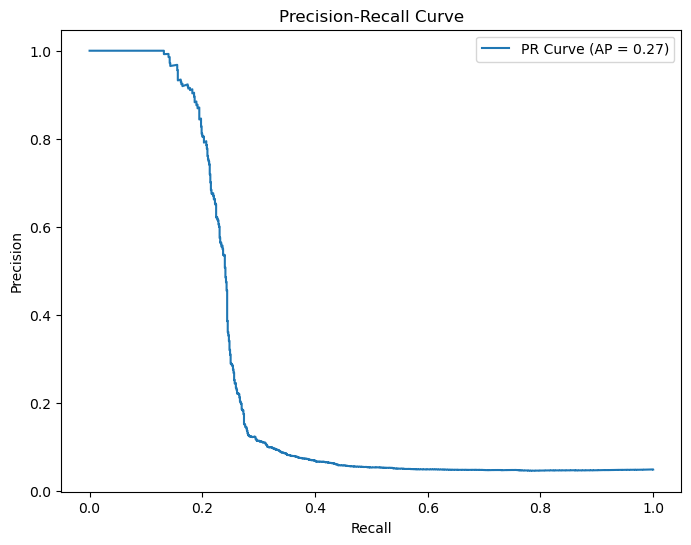

In [37]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

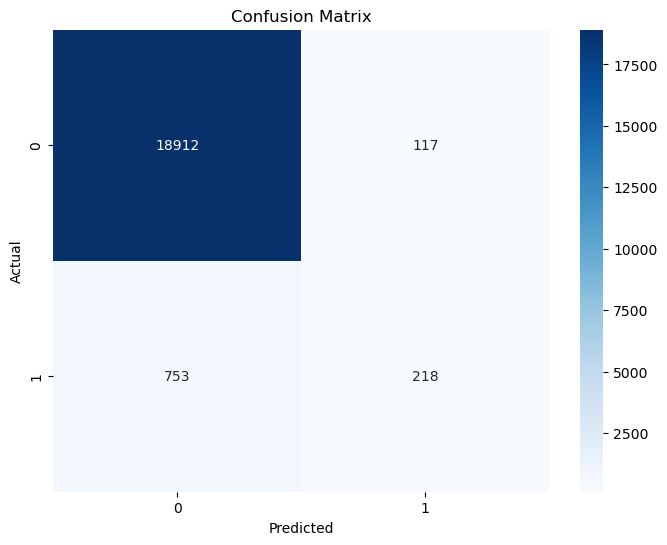

In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [41]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     19029
           1       0.65      0.22      0.33       971

    accuracy                           0.96     20000
   macro avg       0.81      0.61      0.66     20000
weighted avg       0.95      0.96      0.95     20000



In [ ]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Anomaly_Score': anomaly_scores_normalized
})

# Display the first few rows of the results
print("\nSample of Actual vs Predicted Values:")
print(results_df.head(20))